In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp

from matplotlib import pyplot as plt
from helpers import (
    draw_edges, get_borderless_fig, pos_spring_layout, signed_layout, get_lcc, signed_normalized_laplacian, flatten,
    pos_adj, neg_adj
)
from viz_helpers import draw_query_result
from stat_helpers import populate_fields

In [3]:
def get_row_by_query(query):
    return df[df['query'] == query].iloc[0]

def show(q, **kwargs):
    r = get_row_by_query(q)
    fig, ax = draw_query_result(g, r['C1'], r['C2'], show_query=True, r=r, **kwargs)
    ax.set_title('q:{}, agr:{:.2f}, ham:{:.2f}, opp:{:.2f}, coh:{:.2f}, max_posdeg:{:.2f}'.format(
        q, r['agreement'], r['ham'], r['opp'], r['coh'], r['max_posdeg']
    ))

In [22]:
graph = 'ref'
g = nx.read_gpickle('graphs/{}.pkl'.format(graph))
A = nx.adj_matrix(g, weight='sign')
df = pd.read_pickle('outputs/{}.pkl'.format(graph))

In [23]:
pos_A, neg_A = pos_adj(A), neg_adj(A)

# for weighted matrix, make it unweighted
if not (pos_A.data == 1).all():
    pos_A.data = np.ones(pos_A.data.shape, dtype='float64')
if not (neg_A.data == 1).all():
    neg_A.data = np.ones(neg_A.data.shape, dtype='float64')

## filtering

exclude those that:

- C1 or C2 is small (<10 nodes)
- k != 200

In [24]:
df = df[df['k'] == 400]

df['size1'] = df['C1'].apply(lambda d: d.shape[0])
df['size2'] = df['C2'].apply(lambda d: d.shape[0])
df['balancedness'] = np.minimum(df['size1'], df['size2']) / (df['size1'] + df['size2'])

df = df[(df['size1'] > 10) & (df['size2'] > 10)]

## data fields to add

- query degree
- avg pos/neg degree inside C1|C2
- opposition between C1 and C2

In [25]:
df['qdeg'] = df['query'].apply(lambda n: g.degree(n))
df = populate_fields(df, pos_A, neg_A)

filtering opp|coh=0 rows


In [26]:
df[['size1', 'size2', 'posdeg1', 'posdeg2', 'negdeg1', 'negdeg2', 'opp', 'agreement']].head(3)

,size1,size2,posdeg1,posdeg2,negdeg1,negdeg2,opp,agreement
108,17,14,1.882353,0.428571,0.000000,0.0,0.046218,1.000000
175,17,39,1.647059,0.461538,0.000000,0.0,0.048265,1.000000
246,327,68,4.226300,0.264706,0.006116,0.0,0.004677,0.965186


In [27]:
fields_to_show = ['query', 'best_beta', 'size1', 'size2', 'agreement', 'ham', 'coh', 'opp', 'max_posdeg']

In [28]:
def show_top_k_by(by, k=3):
    print(df[fields_to_show].sort_values(by=by, ascending=False).head(k))    
    queries = df.sort_values(by=by, ascending=False).head(k)['query'].tolist()
    for q in queries:
        show(q)    
     
    # special treatment to "word" graph
    if graph == 'word':
        queries = df.sort_values(by=by, ascending=False).head(3)['query'].tolist()
        for q in queries:
            r = get_row_by_query(q)
            print('q:', q)
            print('C1:', ', '.join([g.graph['i2w'][n] for n in r['C1']]))
            print('C2:', ', '.join([g.graph['i2w'][n] for n in r['C2']]))        
            print()        

## top-k by HAM

     query  best_beta  size1  size2  agreement       ham       coh       opp  \
108   3436   0.880000     17     14        1.0  0.057281  0.075307  0.046218   
175    834   0.913928     17     39        1.0  0.052498  0.057543  0.048265   
397   2522   0.883721     20     12        1.0  0.051130  0.052313  0.050000   

     max_posdeg  
108    1.882353  
175    1.647059  
397    1.700000  


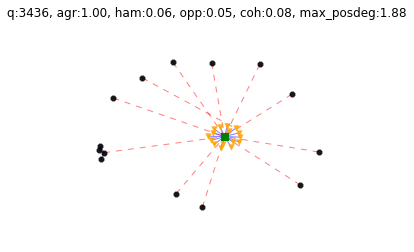

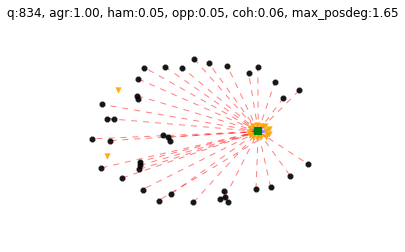

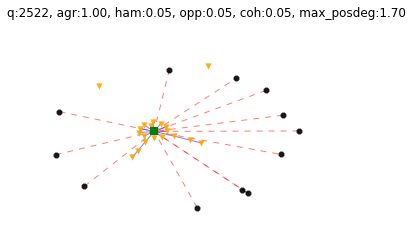

In [29]:
show_top_k_by('ham')

## top-k by agreement

      query  best_beta  size1  size2  agreement       ham       coh       opp  \
5998     11   0.854993     90     16        1.0  0.011173  0.011236  0.011111   
5116   2711   0.893617     34     12        1.0  0.032169  0.046791  0.024510   
3682   3436   0.880000     17     14        1.0  0.057281  0.075307  0.046218   

      max_posdeg  
5998    2.000000  
5116    1.588235  
3682    1.882353  


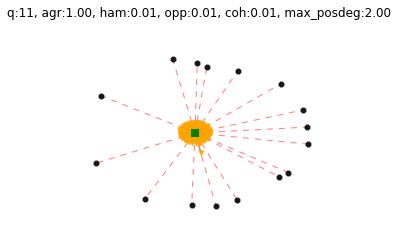

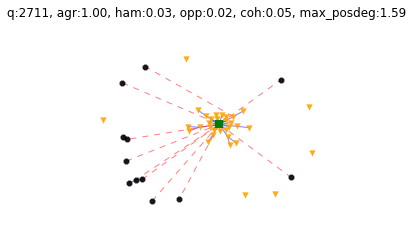

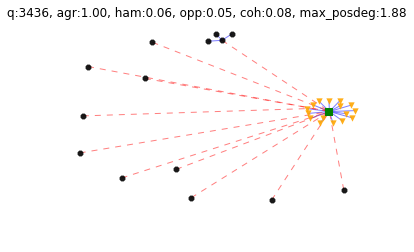

In [13]:
show_top_k_by('agreement')

## top-k by opposition

      query  best_beta  size1  size2  agreement       ham       coh       opp  \
640     666   0.908517     19     11        1.0  0.052632  0.052632  0.052632   
3578   2235   0.909548     19     11        1.0  0.049536  0.046784  0.052632   
396    2522   0.883721     20     12        1.0  0.051130  0.052313  0.050000   

      max_posdeg  
640     1.894737  
3578    1.684211  
396     1.700000  


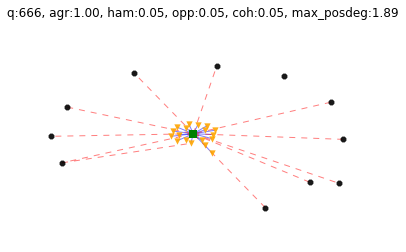

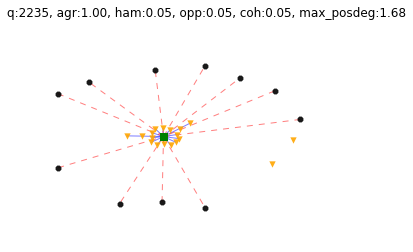

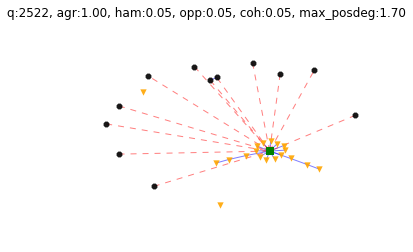

In [14]:
show_top_k_by('opp')

## top-k by coherence

      query  best_beta  size1  size2  agreement       ham       coh       opp  \
4581   1992   0.846743     15     12        1.0  0.028709  0.103463  0.016667   
1985    284   0.838631     25     14        1.0  0.028433  0.083278  0.017143   
344    2596   0.899160     15     13        1.0  0.025701  0.078022  0.015385   

      max_posdeg  
4581    1.333333  
1985    1.428571  
344     1.466667  


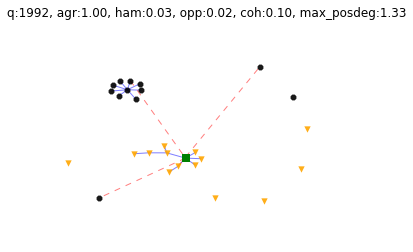

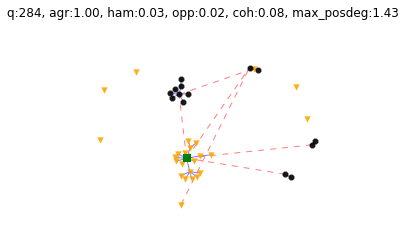

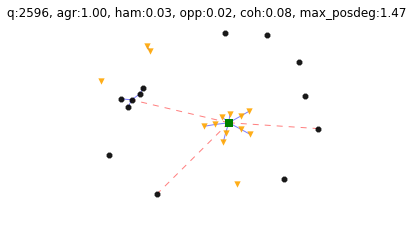

In [15]:
show_top_k_by('coh')

      query  best_beta  size1  size2  agreement       ham       coh       opp  \
4056   2250   0.884274    173     26   0.980237  0.015446  0.022412  0.011783   
1176    943   0.741340    170     13   0.997455  0.006239  0.013331  0.004072   
5507    788   0.857291    153     44   0.990408  0.013602  0.022204  0.009804   

      max_posdeg  
4056    5.063584  
1176    4.505882  
5507    4.339869  


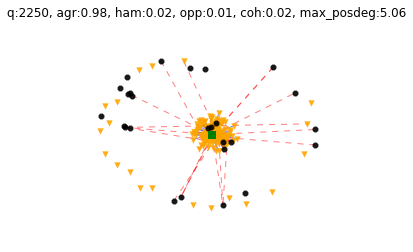

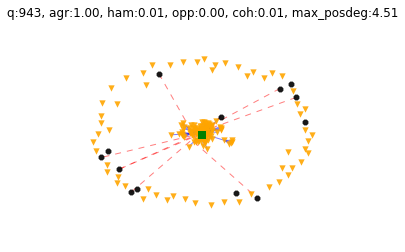

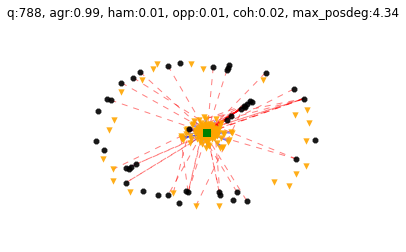

In [16]:
show_top_k_by('max_posdeg')